# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 3 - Deep Reinforcement Learning

## General overview: 

In this homework you will learn how to implement and test neural network models for 
solving reinforcement learning problems. The basic tasks for the homework will require to implement some 
extensions to the code that you have seen in the Lab. The advanced tasks will require to train and test your 
learning agent on a different type of input (image pixels) or Gym environment. You can just choose one of 
the advanced tasks to get the maximum grade. If you are interested in improving your skills, feel free to try 
both advanced tasks. Given the higher computational complexity of RL, in this homework you don’t need to 
tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged 
to play with model hyperparameters to find a satisfactory configuration.


##Final report: 

Along with the source code, you must separately upload a PDF file containing a brief report of 
your homework. The report should include a brief Introduction on which you explain the homework goals 
and the main implementation strategies you choose, a brief Method section where you describe your 
model architectures and hyperparameters, and a Result section where you present the simulation results. 
Total length must not exceed 6 pages, though you can include additional tables and figures in a final 
Appendix (optional). The report must be self-contained, so please make sure that all relevant results are 
explicitly included in the report / notebook. Given the dynamical nature of RL problems, you can explore 
more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).

##Grade: 

The maximum grade for this homework will be 8 points. Points will be assigned based on the correct 
implementation of the following items:

• 3 pt: use the notebook of Lab 07 to study how the exploration profile (either using eps-greedy or 
softmax) impacts the learning curve. Tune a bit the model hyperparameters or tweak the reward 
function to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).

• 5 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using 
directly the screen pixels, rather than the compact state representation used during the Lab (cart 
position, cart velocity, pole angle, pole angular velocity). NB: this will require to change the 
“observation_space” and to look for smart ways of encoding the pixels in a compact way to reduce 
computational complexity (e.g., crop the image around the pole, use difference of consecutive frames 
as input to consider temporal context, etc.).

or

• 5 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym 
environment you like from the available list, or even explore other simulation platforms

In [22]:
#!pip uninstall gym==0.23.1

In [4]:
!pip install gym==0.22.0 #newer version has deprecated the Monitor function


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 3.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708398 sha256=f987b8c85f5a7a04ac10c6a99b218345b0bdc3feb33b053d0346494af94b5614
  Stored in directory: /root/.cache/pip/wheels/7d/5e/87/7d50e0179edda70feff5bba05c381041e1c1fd80c6b06a4cc3
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [1]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

In [2]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 46.1 MB/s 


In [65]:
import random
import torch
import numpy as np
import pygame
import gym
from gym.wrappers import Monitor
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

device = torch.device("cuda") if (torch.cuda.is_available()) else torch.device("cpu")
print(device)

cpu


# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [66]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [67]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [68]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Network definition

In [7]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
              nn.Linear(state_space_dim, 128),
              nn.Tanh(),
              nn.Linear(128,128),
              nn.Tanh(),
              nn.Linear(128, action_space_dim)
              )

    def forward(self, x):
        return self.linear(x)

In [8]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [9]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [10]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [ 0.10682802 -0.1139013 ]


### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

In [11]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [12]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [ 0.10682802 -0.1139013 ]


### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

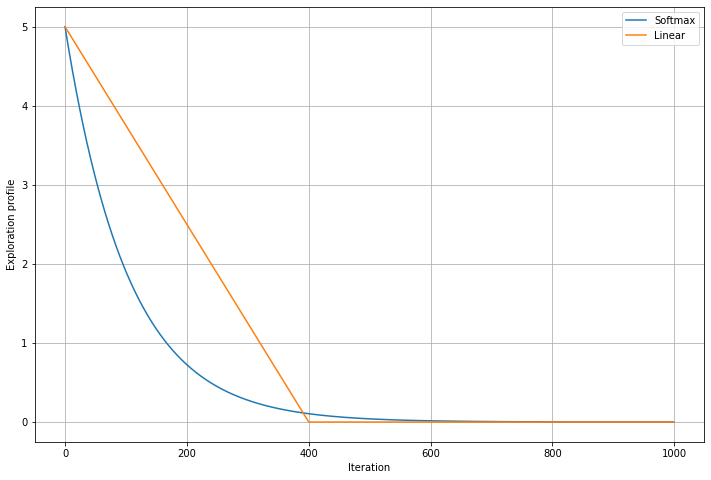

In [13]:
### Define exploration profile
initial_value = 5
num_iterations = 1000

def softmax_expl(num_iterations, initial_value):
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
    exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])
    
    return exploration_profile

def linear_expl(num_iterations, initial_value, end_value=0, until_point=400):
    #decays linearly until until_point and then it is end_value
    decay = np.array([initial_value - (initial_value-end_value)/ until_point *  i for i in range(until_point)])
    const = np.ones(num_iterations - until_point) * end_value
    exploration_profile = np.hstack((decay, const))

    return exploration_profile

exploration_profile_softmax = softmax_expl(num_iterations, initial_value)
exploration_profile_linear = linear_expl(num_iterations, initial_value)
### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile_softmax, label="Softmax")
plt.plot(exploration_profile_linear, label="Linear")
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')
plt.show()

# Gym Environment (CARTPOLE-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

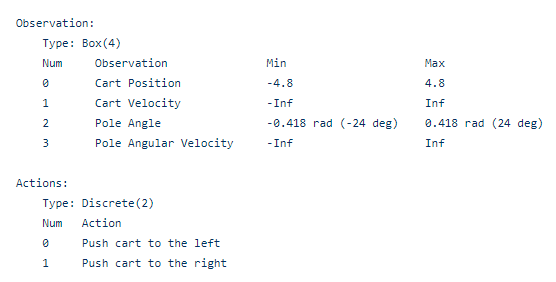

In [38]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


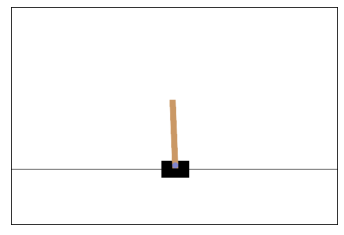

In [39]:
# Visualise the simulation
state = env.reset()
# Images are 600x400 pixels
s_shot = env.render(mode='rgb_array')
s_shot = np.ascontiguousarray(s_shot, dtype=np.float32)/255.
env.close()
plt.imshow(s_shot)
plt.yticks([]);
plt.xticks([]);

## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [40]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 33.0
EPISODE 2 - FINAL SCORE: 21.0
EPISODE 3 - FINAL SCORE: 73.0
EPISODE 4 - FINAL SCORE: 13.0
EPISODE 5 - FINAL SCORE: 19.0
EPISODE 6 - FINAL SCORE: 17.0
EPISODE 7 - FINAL SCORE: 16.0
EPISODE 8 - FINAL SCORE: 16.0
EPISODE 9 - FINAL SCORE: 14.0
EPISODE 10 - FINAL SCORE: 30.0


In [41]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.4612.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.4612.video000009.mp4


# Network update

## Update function

In [40]:
def update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params):
    gamma = params['gamma']
    batch_size = params['batch_size']
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop (advanced)
Let's modify the reward to improve the results.

In [43]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, params, verbose=False):
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(1999) # Set a random seed for the environment (reproducible results)

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1
            reward = reward - pos_weight * np.abs(state[0]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += bad_state_penalty #params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params)

            # Visually render the environment (disable to speed up the training)
            #if episode_num % 100 == 0:
            #   env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [24]:
def initialize(params, replay_memory_capacity=10000, state_space_dim=4, action_space_dim=2):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['lr']) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

# Optimisation of parameters

In [45]:
params_to_opt = {'profile_type' : ['linear', 'softmax'],
                 'lr': np.logspace(-3, -1, 10),   # Optimizer learning rate
                 'initial_temp' : [1,2,3,4,5,6,7,8,9,10],
                 'target_net_update_steps'  : [5,10,15,20,25],
                 'gamma': np.linspace(0.9, 0.99, 10),
                 'batch_size': [32, 64, 128, 256], 
}

In [46]:
def random_params(params):
    selected_params = {}
    for i in params.keys():
        selected_params[i] = np.random.choice( params[i] )
    return selected_params

print(random_params(params_to_opt))

{'profile_type': 'linear', 'lr': 0.001, 'initial_temp': 5, 'target_net_update_steps': 15, 'gamma': 0.92, 'batch_size': 64}


In [47]:
# exploration profile generation

def get_expl_profile(params):
    initial_value = params.get('initial_temp')
    if params.get('profile_type')=='linear':
      expl_profile = linear_expl(num_iterations, initial_value)

    if params.get('profile_type')=='softmax':
      expl_profile = softmax_expl(num_iterations, initial_value)

    return expl_profile 


In [48]:
### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [49]:
## try to find best model
# due to computation time we will search only over 500 iterations (after all we just want to find the quickest one to win)
# test 50 different configurations of exploration profiles, set of parameters
env.seed(0)

num_iterations = 500

#outputs
all_params = []
all_train_scores = []
all_expl_profiles = []

for net in range(50):
    
    ### PARAMETERS
    current_params = random_params(params_to_opt)
    print('Model', net, '...')

    ### Set exploration profile
    exploration_profile =  get_expl_profile(current_params)

    ### Initialization
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(current_params)
    
    ### Training
    policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, current_params)
    
    all_params.append(current_params)
    all_train_scores.append(training_score)
    all_expl_profiles.append(exploration_profile)

Model 0 ...


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if __name__ == '__main__':


Model 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 10 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 11 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 12 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 13 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 14 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 15 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 16 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 17 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 18 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 19 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 20 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 21 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 22 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 23 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 24 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 25 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 26 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 27 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 28 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 29 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 30 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 31 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 32 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 33 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 34 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 35 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 36 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 37 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 38 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 39 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 40 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 41 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 42 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 43 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 44 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 45 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 46 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 47 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 48 ...


  0%|          | 0/500 [00:00<?, ?it/s]

Model 49 ...


  0%|          | 0/500 [00:00<?, ?it/s]

In [82]:
def plot_profile_score(exploration_profile, score, params):
    
    score = np.array(score)
       
    ### Plot exploration profile
    fig, ax = plt.subplots(figsize=(10,6))

    fig.suptitle('Network trial: {}'.format(all_params.index(params)), fontsize=12, y=0.92)

    col = 'deeppink'
    ax.set_xlabel('Iteration', fontsize=14)
    ax.set_ylabel('Exploration profile', c=col, fontsize=14)
    ax.plot(exploration_profile, c=col, linewidth=1.5)
    ax.tick_params(axis='y', labelcolor=col)
    
    ax2 = ax.twinx()  # saem x axis, different ys
    
    col = 'steelblue'
    ax2.set_ylabel('Final score', c=col, fontsize=14)  # we already handled the x-label with ax1
    ax2.plot(score, c=col, linewidth=0.7)
    ax2.tick_params(axis='y', labelcolor=col)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

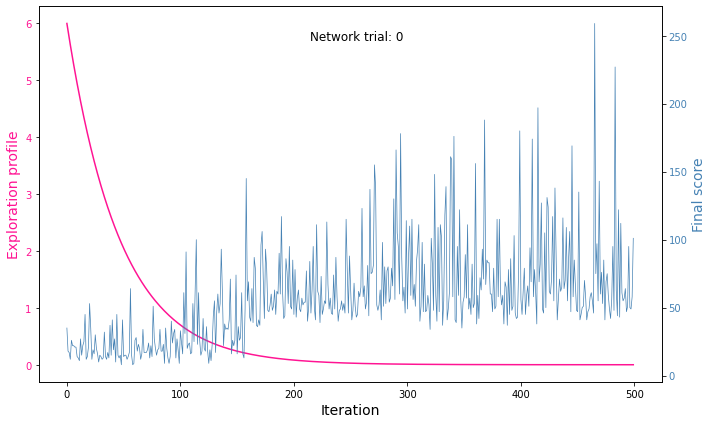

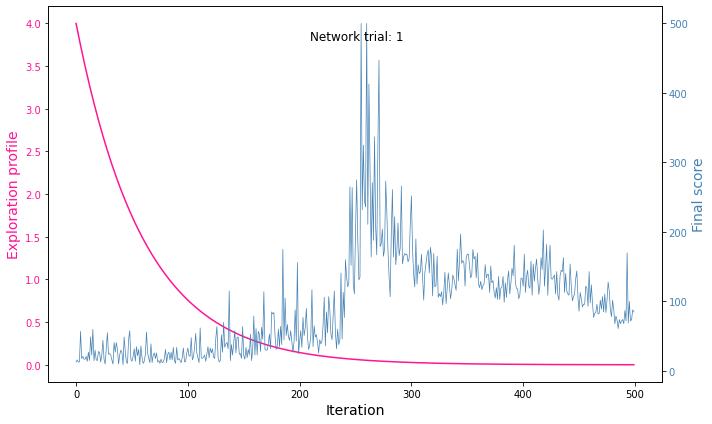

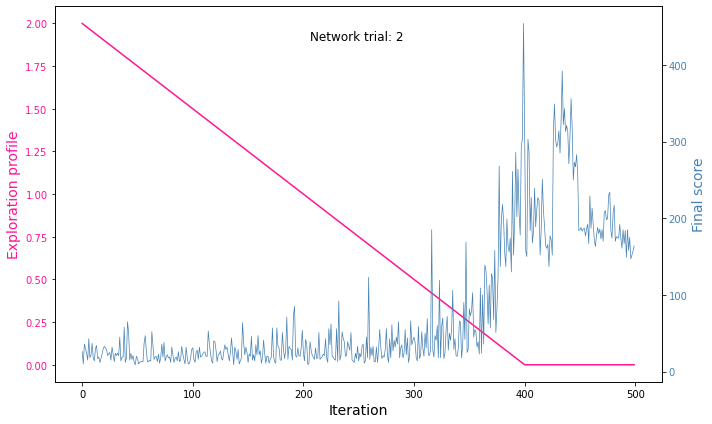

In [83]:
for i in range(3):
  plot_profile_score(all_expl_profiles[i], all_train_scores[i], all_params[i])

# The best model

In [73]:
print(all_train_scores[3][499])
len(all_expl_profiles)


89


50

In [81]:
#to find the best model we need to find the one which reaches the top score the quickest

#find index of each model that achieves the top score
indexes = np.zeros(len(all_expl_profiles))

for i, index in enumerate(indexes):
  
  if 500 in all_train_scores[i] and all_train_scores[i][499] == 500:
    first = all_train_scores[i].index(500)
    indexes[i] = first

print("The iteration that first gets 500 points is", np.min(indexes[np.nonzero(indexes)]))

#find number of model which gets to 500 quickest
model_id = indexes.tolist().index(np.min(indexes[np.nonzero(indexes)]))
print("The model is number", model_id, "in the list of trials")

The iteration that first gets 500 points is 338.0
The model is number 16 in the list of trials


In [78]:
best_params = all_params[model_id]
print(best_params)

{'profile_type': 'linear', 'lr': 0.05994842503189409, 'initial_temp': 2, 'target_net_update_steps': 5, 'gamma': 0.98, 'batch_size': 128}


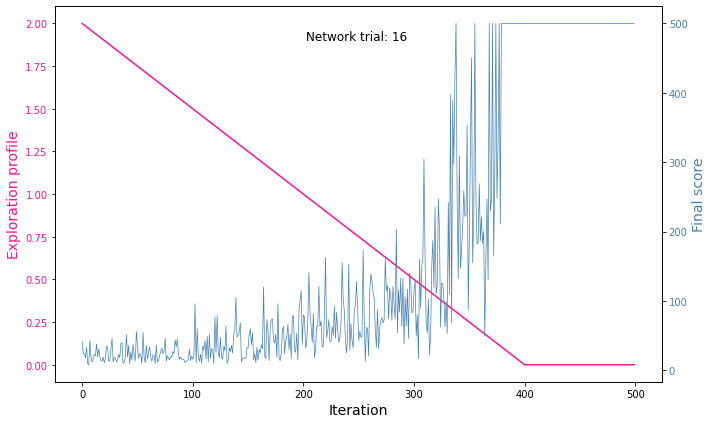

In [84]:
plot_profile_score(all_expl_profiles[model_id], all_train_scores[model_id], all_params[model_id])

# Best model test

In [85]:
best_param_set = {'profile_type' : best_params.get('profile_type'),
                 'lr': best_params.get('lr'),
                 'initial_temp' : best_params.get('initial_temp'),
                 'target_net_update_steps'  : best_params.get('target_net_update_steps'),
                 'gamma': best_params.get('gamma'),
                 'batch_size': best_params.get('batch_size') 
}

In [86]:
# now train for 1000 epochs
num_iterations = 1000
# Initialise
final_replay_mem, final_policy_net, final_target_net, optimizer, loss_fn = initialize(best_param_set) 


exploration_profile =  get_expl_profile(best_param_set)

# Train
final_policy_net, final_training_score = training_loop(final_policy_net, final_target_net, final_replay_mem, 
                                                    exploration_profile, best_param_set)
# save the network
torch.save(final_policy_net.state_dict(), 'best_cartpole')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [87]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0)

## LOAD FINAL NETWORK
final_policy_net.load_state_dict(torch.load('best_cartpole'))
final_policy_net.to(device)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(final_policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [88]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.1.4612.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000001.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000002.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000003.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000004.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000005.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000006.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000007.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000008.mp4



SHOWING VIDEO video/openaigym.video.1.4612.video000009.mp4


# Acrobot-v1

In [14]:
### Create environment
env = gym.make('Acrobot-v1') # Initialize the Gym environment
# Set a random seed for the environment (reproducible results)
env.seed(0)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


In [15]:
# Define an example network
net = DQN(state_space_dim, action_space_dim)
net

DQN(
  (linear): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

## Random Agent

In [20]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, 'acrobot_random', video_callable=lambda episode_id: True)
env = wrap_env(env, video_callable=lambda episode_id: True)


# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until 500 timestep limit or pendulum reaches goal
    while not done:
      # Choose a random action
      action = random.choice([1,0,-1]) #the possible actions 
      #are either applying +1, 0 or -1 torque to the joint between the pendulum links
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the score with the reward
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

EPISODE 1 - FINAL SCORE: -500.0
EPISODE 2 - FINAL SCORE: -500.0
EPISODE 3 - FINAL SCORE: -500.0
EPISODE 4 - FINAL SCORE: -500.0
EPISODE 5 - FINAL SCORE: -500.0
EPISODE 6 - FINAL SCORE: -500.0
EPISODE 7 - FINAL SCORE: -500.0
EPISODE 8 - FINAL SCORE: -500.0
EPISODE 9 - FINAL SCORE: -500.0
EPISODE 10 - FINAL SCORE: -500.0


In [21]:
show_videos()


SHOWING VIDEO video/openaigym.video.2.1248.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.1248.video000009.mp4


## Training Loop Acrobot-v1

In [38]:
def training_loop_acro(policy_net, target_net, replay_mem, exploration_profile, params):
       
    # Initialize the Gym environment
    env = gym.make('Acrobot-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    
    scores = []
    
    # This is for creating the output video in Colab, not required outside Colab
#     env = wrap_env(env, "Moon_train" , video_callable = lambda episode_id: episode_id % 10 == 0) # Save a video every 100 episodes

    min_samples_for_training = params.get('min_samples_for_training')

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the conditions are met
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            
            #reward = reward - x_pos_weight * np.abs(state[0]) - y_pos_weight * np.abs(state[1]) - angle_weight * min(0, state[4])

            # Update the final score with the reward
            score += reward

            # Apply penalty for bad state
            if done: # if the ship has crashed
                reward += params.get('bad_state_penalty')
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, optimizer, loss_fn, params)

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params.get('target_net_update_steps') == 0:
            print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        
        scores.append(score)
        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

    env.close()
    return policy_net, scores

In [51]:
acro_params = {'gamma': 0.99,                   # gamma parameter for the long term reward
              'replay_memory_capacity': 10000, # Replay memory capacity
              'lr': 0.001,            # Optimizer learning rate
              'target_net_update_steps': 10,    # Number of episodes to wait before updating the target network
              'batch_size': 256,                # Number of samples to take from the replay memory for each update
              'bad_state_penalty': 0,          # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
              'min_samples_for_training': 1000 # Minimum samples in the replay memory to enable the training
             }

In [52]:
num_iterations = 800

### Initialization
replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(acro_params, action_space_dim=action_space_dim, state_space_dim=state_space_dim)

exploration_profile = softmax_expl(num_iterations, initial_value)

### Training
acro_policy_net, acro_training_score = training_loop_acro(policy_net, target_net, replay_mem, exploration_profile, acro_params)

# save the network
torch.save(acro_policy_net.state_dict(), 'acrobot')

  0%|          | 0/800 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - Temperature: 4.940008876649582
EPISODE: 3 - FINAL SCORE: -500.0 - Temperature: 4.880737540275333
EPISODE: 4 - FINAL SCORE: -500.0 - Temperature: 4.822177354711398
EPISODE: 5 - FINAL SCORE: -500.0 - Temperature: 4.764319787410582
EPISODE: 6 - FINAL SCORE: -500.0 - Temperature: 4.707156408201104
EPISODE: 7 - FINAL SCORE: -500.0 - Temperature: 4.650678888058284
EPISODE: 8 - FINAL SCORE: -500.0 - Temperature: 4.594878997890946
EPISODE: 9 - FINAL SCORE: -500.0 - Temperature: 4.539748607342402
EPISODE: 10 - FINAL SCORE: -500.0 - Temperature: 4.485279683605809
Updating target network...
EPISODE: 11 - FINAL SCORE: -466.0 - Temperature: 4.431464290253745
EPISODE: 12 - FINAL SCORE: -500.0 - Temperature: 4.378294586081827
EPISODE: 13 - FINAL SCORE: -500.0 - Temperature: 4.325762823966207
EPISODE: 14 - FINAL SCORE: -500.0 - Temperature: 4.273861349734766
EPISODE: 15 - FINAL SCORE: -500

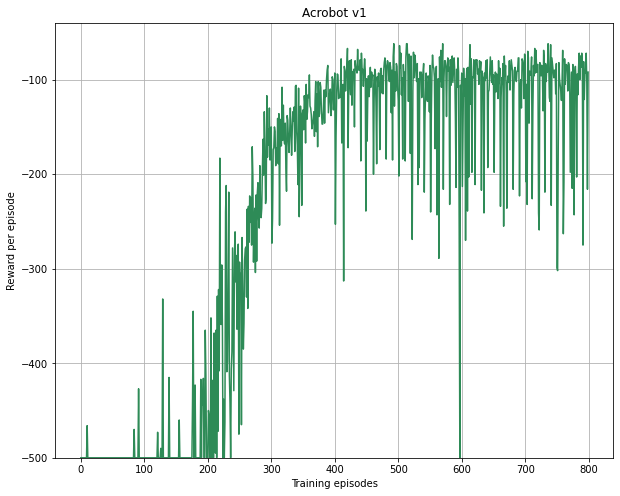

In [62]:
#plot training
acro_training_score = np.array(acro_training_score)
plt.figure(figsize=(10,8))
plt.plot(range(0,800), acro_training_score, c='seagreen')
plt.xlabel('Training episodes')
plt.ylabel('Reward per episode')
plt.ylim([-500,-40])
plt.grid()
plt.title('Acrobot v1')
plt.show()

## Test final performance

In [71]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0)

## LOAD FINAL NETWORK
acro_policy_net.load_state_dict(torch.load('acrobot'))
acro_policy_net.to(device)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(acro_policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -85.0
EPISODE 2 - FINAL SCORE: -82.0
EPISODE 3 - FINAL SCORE: -97.0
EPISODE 4 - FINAL SCORE: -91.0
EPISODE 5 - FINAL SCORE: -116.0
EPISODE 6 - FINAL SCORE: -72.0
EPISODE 7 - FINAL SCORE: -104.0
EPISODE 8 - FINAL SCORE: -157.0
EPISODE 9 - FINAL SCORE: -70.0
EPISODE 10 - FINAL SCORE: -84.0


In [73]:
show_videos()


SHOWING VIDEO video/openaigym.video.6.1248.video000000.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000001.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000002.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000003.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000004.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000005.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000006.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000007.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000008.mp4



SHOWING VIDEO video/openaigym.video.6.1248.video000009.mp4
